from Kaggle:
https://www.kaggle.com/c/dont-overfit-ii/overview

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV

np.random.seed(42)

## O que sabemos sobre o dataset?

In [44]:
overfit_train_data = pd.read_csv('./data/train.csv',index_col='id')
overfit_test_data  = pd.read_csv("./data/test.csv",index_col='id')

print(f"Temos um dataset com {overfit_train_data.shape[1]-1} features")

Temos um dataset com 300 features


0

In [39]:
dic = {}
for col in overfit_train_data:
    dic[col] = []
    dic[col].append(len(overfit_train_data[col].unique()))
    dic[col].append(overfit_train_data[col].isnull().sum())
pd.DataFrame.from_dict(data=dic,orient='index',columns=['number','missing values'])

,number,missing values
target,2,0
0,242,0
1,241,0
2,240,0
3,242,0
...,...,...
295,243,0
296,240,0
297,241,0
298,242,0


# Resolução com Todas as Features

            Mean        Std   Acc
SVC         71.5  12.257651  80.0
Log_Reg     65.5  12.134661  80.0
Grad_Boost  68.5  15.337862  70.0


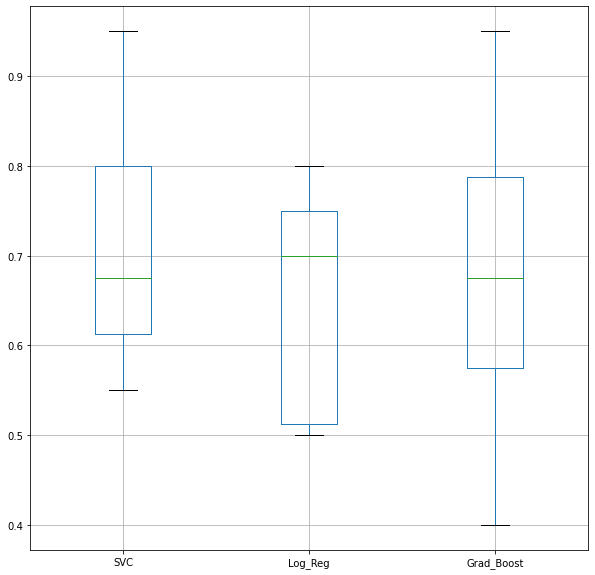

In [10]:
TEST_SIZE = 0.2
STRATEGY_NUM = 'mean'
SCORING = 'accuracy' #'roc_auc' #
N_SPLITS = 10


X = overfit_train_data.drop(columns='target')
y = overfit_train_data.loc[:,'target']

# Antes de mais nada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)

# Applying Standard Scaler
NUM_FEAT = X.columns.values
scaler = StandardScaler()
num_transf = Pipeline([('Scaler',scaler)])

preprocessor = ColumnTransformer(transformers=[
    ('Numeric',num_transf,NUM_FEAT)
])

svc = SVC(random_state=RANDOM_SEED)
log_reg = LogisticRegression(random_state=RANDOM_SEED) #C=6, #penalty='l2'
                             #class_weight='balanced', #0.1
                             #max_iter=10000,
                             #solver='lbfgs',
                             #n_jobs=-1,
grad_boost = GradientBoostingClassifier(random_state=RANDOM_SEED)
kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

# list models
list_models = [('SVC', svc), ('Log_Reg', log_reg), ('Grad_Boost', grad_boost)]

df_summary = pd.DataFrame(columns=['Mean','Std','Acc'])
df_scores = pd.DataFrame()

X_final = overfit_train_data

# cross-val, treino e avalicao tudo num for
for name, model in list_models:
    pipe = Pipeline([('Preprocessor', preprocessor), (name, model)])
    scores = cross_val_score(pipe, X_train, y_train, scoring=SCORING, cv=kfold)
    df_scores.loc[:, name] = scores
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    df_summary.loc[name] = [scores.mean()*100, 
                            scores.std()*100,
                           accuracy_score(y_test, y_pred)*100]
    
    # Wrinting the output for Kaggle
    y_pred_final = pipe.predict(X_final)
    output = pd.DataFrame({'id': X_final.index, 'target': y_pred_final})
    output.to_csv(f'./outputs/{name} DontOverfit 2020-11-22.csv',index=False)

print(df_summary)
df_scores.boxplot(figsize=(10, 10))
plt.show()

# Com apenas as features selecionadas

In [27]:
s = overfit_train_data.corr()['target'].sort_values(ascending=False)
selected_columns = s.loc[s>0.1].index.values[1:]

            Mean        Std   Acc
SVC         75.5   6.873864  82.0
Log_Reg     76.0   9.433981  80.0
Grad_Boost  68.5  12.459936  80.0


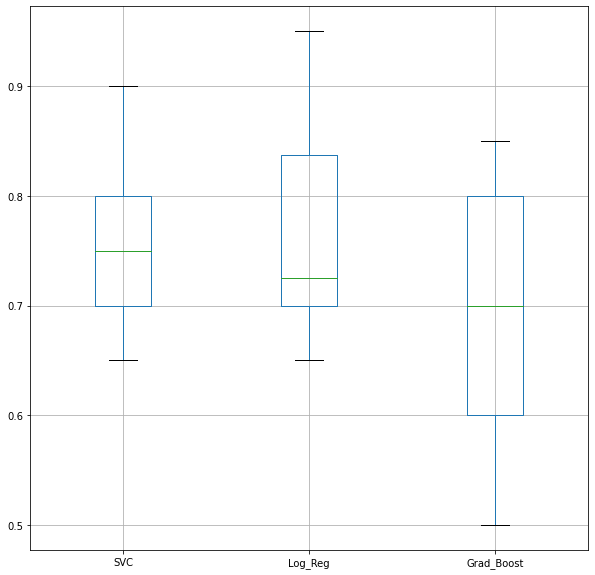

In [40]:
TEST_SIZE = 0.2
STRATEGY_NUM = 'mean'
SCORING = 'accuracy' #'roc_auc' #
N_SPLITS = 10


X = overfit_train_data[selected_columns]
y = overfit_train_data.loc[:,'target']

# Antes de mais nada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)

# Applying Standard Scaler
NUM_FEAT = selected_columns
scaler = StandardScaler()
num_transf = Pipeline([('Scaler',scaler)])

preprocessor = ColumnTransformer(transformers=[
    ('Numeric',num_transf,NUM_FEAT)
])

svc = SVC()
log_reg = LogisticRegression() #C=6, #penalty='l2'
                             #class_weight='balanced', #0.1
                             #max_iter=10000,
                             #solver='lbfgs',
                             #n_jobs=-1,
grad_boost = GradientBoostingClassifier()
kfold = KFold(n_splits=N_SPLITS, shuffle=True)

# list models
list_models = [('SVC', svc), ('Log_Reg', log_reg), ('Grad_Boost', grad_boost)]

df_summary = pd.DataFrame(columns=['Mean','Std','Acc'])
df_scores = pd.DataFrame()

X_final = overfit_test_data[selected_columns]

# cross-val, treino e avalicao tudo num for
for name, model in list_models:
    pipe = Pipeline([('Preprocessor', preprocessor), (name, model)])
    scores = cross_val_score(pipe, X_train, y_train, scoring=SCORING, cv=kfold)
    df_scores.loc[:, name] = scores
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    df_summary.loc[name] = [scores.mean()*100, 
                            scores.std()*100,
                           accuracy_score(y_test, y_pred)*100]
    
    # Wrinting the output for Kaggle
    y_pred_final = pipe.predict(X_final)
    output = pd.DataFrame({'id': X_final.index, 'target': y_pred_final})
    output.to_csv(f'./outputs/{name} DontOverfit Few Columns 2020-11-22.csv',index=False)

print(df_summary)
df_scores.boxplot(figsize=(10, 10))
plt.show()

# Excluindo e Normalizando

            Mean        Std   Acc
SVC         71.0   8.888194  82.0
Log_Reg     70.5   7.228416  72.0
Grad_Boost  70.0  10.488088  80.0


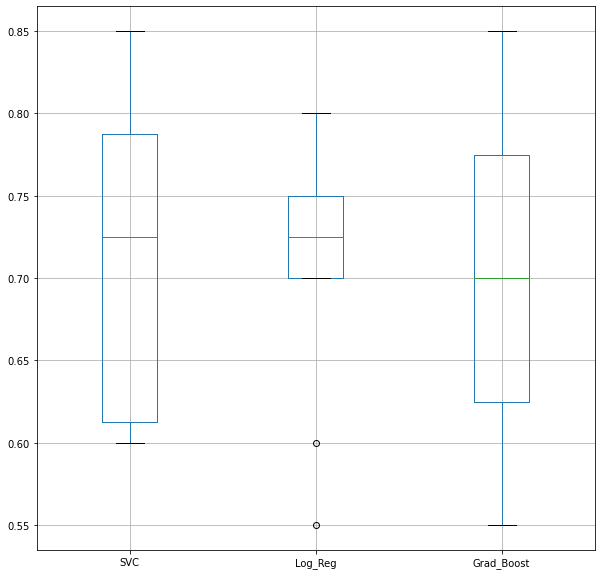

In [45]:
TEST_SIZE = 0.2
STRATEGY_NUM = 'mean'
SCORING = 'accuracy' #'roc_auc' #
N_SPLITS = 10


X = overfit_train_data.drop(columns='target')
y = overfit_train_data.loc[:,'target']

# Antes de mais nada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)

# Applying Standard Scaler
NUM_FEAT = X.columns.values
selector = VarianceThreshold(threshold=0.0)
scaler = StandardScaler()
num_transf = Pipeline([('Select',selector),('Scaler',scaler)])

preprocessor = ColumnTransformer(transformers=[
    ('Numeric',num_transf,NUM_FEAT)
])

svc = SVC()
log_reg = LogisticRegression() #C=6, #penalty='l2'
                             #class_weight='balanced', #0.1
                             #max_iter=10000,
                             #solver='lbfgs',
                             #n_jobs=-1,
grad_boost = GradientBoostingClassifier()
kfold = KFold(n_splits=N_SPLITS, shuffle=True)

# list models
list_models = [('SVC', svc), ('Log_Reg', log_reg), ('Grad_Boost', grad_boost)]

df_summary = pd.DataFrame(columns=['Mean','Std','Acc'])
df_scores = pd.DataFrame()

X_final = overfit_test_data

# cross-val, treino e avalicao tudo num for
for name, model in list_models:
    pipe = Pipeline([('Preprocessor', preprocessor), (name, model)])
    scores = cross_val_score(pipe, X_train, y_train, scoring=SCORING, cv=kfold)
    df_scores.loc[:, name] = scores
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    df_summary.loc[name] = [scores.mean()*100, 
                            scores.std()*100,
                           accuracy_score(y_test, y_pred)*100]
    
    # Wrinting the output for Kaggle
    y_pred_final = pipe.predict(X_final)
    output = pd.DataFrame({'id': X_final.index, 'target': y_pred_final})
    output.to_csv(f'./outputs/{name} Selector DontOverfit 2020-11-22.csv',index=False)

print(df_summary)
df_scores.boxplot(figsize=(10, 10))
plt.show()

# Otimizando Parâmetros 2020-10-26

In [10]:
# parameter optimization
import optuna

def objective(trial):
    C=trial.suggest_loguniform('C', 0.00001, 100)
    model=LogisticRegression(C=C, class_weight='balanced',max_iter=10000, solver='lbfgs', n_jobs=-1)
    pipe = Pipeline([('Preprocessor', preprocessor), ('Log_Reg', model)])
    score=-cross_val_score(pipe, X_train, y_train, cv=kfold, scoring='roc_auc').mean()
    return score
study=optuna.create_study()

[I 2020-10-26 18:01:16,078] A new study created in memory with name: no-name-69a6da8e-7d57-46e1-b6cc-20fe8ea959b0


In [11]:
study.optimize(objective, n_trials=100)

[I 2020-10-26 18:01:22,016] Trial 0 finished with value: -0.6740000000000002 and parameters: {'C': 30.341410124782367}. Best is trial 0 with value: -0.6740000000000002.
[I 2020-10-26 18:01:22,222] Trial 1 finished with value: -0.6762380952380952 and parameters: {'C': 0.00012432338180473634}. Best is trial 1 with value: -0.6762380952380952.
[I 2020-10-26 18:01:22,425] Trial 2 finished with value: -0.686 and parameters: {'C': 0.006123353457973226}. Best is trial 2 with value: -0.686.
[I 2020-10-26 18:01:22,634] Trial 3 finished with value: -0.635904761904762 and parameters: {'C': 0.015925433508401705}. Best is trial 2 with value: -0.686.
[I 2020-10-26 18:01:22,874] Trial 4 finished with value: -0.6616190476190477 and parameters: {'C': 2.099392943149756}. Best is trial 2 with value: -0.686.
[I 2020-10-26 18:01:23,119] Trial 5 finished with value: -0.7130000000000001 and parameters: {'C': 63.52205314590649}. Best is trial 5 with value: -0.7130000000000001.
[I 2020-10-26 18:01:23,353] Trial

[I 2020-10-26 18:01:32,490] Trial 46 finished with value: -0.6943809523809523 and parameters: {'C': 0.0026873601249946953}. Best is trial 39 with value: -0.7359523809523811.
[I 2020-10-26 18:01:32,711] Trial 47 finished with value: -0.7042380952380952 and parameters: {'C': 0.04584509826596827}. Best is trial 39 with value: -0.7359523809523811.
[I 2020-10-26 18:01:32,927] Trial 48 finished with value: -0.6800952380952381 and parameters: {'C': 0.01602597958369642}. Best is trial 39 with value: -0.7359523809523811.
[I 2020-10-26 18:01:33,134] Trial 49 finished with value: -0.6873809523809523 and parameters: {'C': 0.0035667439154466415}. Best is trial 39 with value: -0.7359523809523811.
[I 2020-10-26 18:01:33,352] Trial 50 finished with value: -0.6693333333333333 and parameters: {'C': 0.26200326992333517}. Best is trial 39 with value: -0.7359523809523811.
[I 2020-10-26 18:01:33,586] Trial 51 finished with value: -0.6789999999999999 and parameters: {'C': 0.12082610357408448}. Best is trial 

[I 2020-10-26 18:01:42,459] Trial 91 finished with value: -0.6869047619047619 and parameters: {'C': 0.433866201624369}. Best is trial 39 with value: -0.7359523809523811.
[I 2020-10-26 18:01:42,649] Trial 92 finished with value: -0.6756190476190477 and parameters: {'C': 1.051646866706519e-05}. Best is trial 39 with value: -0.7359523809523811.
[I 2020-10-26 18:01:42,892] Trial 93 finished with value: -0.6738095238095239 and parameters: {'C': 0.8983646211604582}. Best is trial 39 with value: -0.7359523809523811.
[I 2020-10-26 18:01:43,121] Trial 94 finished with value: -0.6931428571428573 and parameters: {'C': 0.09675685999234761}. Best is trial 39 with value: -0.7359523809523811.
[I 2020-10-26 18:01:43,341] Trial 95 finished with value: -0.6532380952380953 and parameters: {'C': 0.05334165065150206}. Best is trial 39 with value: -0.7359523809523811.
[I 2020-10-26 18:01:43,548] Trial 96 finished with value: -0.6545238095238095 and parameters: {'C': 0.01674543478560086}. Best is trial 39 wi

In [12]:
print(study.best_params)
print(-study.best_value)

{'C': 0.028940669044126264}
0.7359523809523811


# Resolução Old

In [ ]:
# constantes
PATH_FILE_TRAIN = 'data/train.csv'
PATH_FILE_TEST = 'data/test.csv'
TEST_SIZE = 0.2
RANDOM_SEED = 42
STRATEGY_NUM = 'mean'
STRATEGY_CAT = 'constant'
SCORING = 'accuracy'
N_SPLITS = 10

df_train = pd.read_csv(PATH_FILE_TRAIN,index_col='id')

# Readign DataFrame for final test
df_test_final = pd.read_csv(PATH_FILE_TEST,index_col='id')

In [ ]:
df_test_final

In [ ]:
X  = df_train.drop(columns='target')
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

scaler = StandardScaler()
log_reg = LogisticRegressionCV(random_state=42)

strat_kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)

# instanciando o pipeline com os passos que queremos
pipeline = Pipeline([('StandardScaler', scaler), # segundo ele faz o StandardScaler 
                     ('LogisticRegression', log_reg)]) # terceiro ele treina o estimador

df_scores = pd.DataFrame()
scores = cross_val_score(pipeline, X_train, y_train, scoring=SCORING, cv=strat_kfold)
df_scores.loc[:, "Log Reg"] = scores

pipeline.fit(X,y)
X_test_final = df_test_final.copy()
X_test_final.loc[:,'target'] = pipeline.predict(X_test_final)
X_test_final['target'].to_csv('Log Reg Out_pipe.csv')
X_test_final = X_test_final.drop(columns='target')

print('Scores do Cross-validation')
print(scores.round(2))
print(f'Media   : {scores.mean():.2f}%')
print(f'Desv Pad: {scores.std():.2f}%')

In [ ]:
scores

In [ ]:
df_scores

In [ ]:
X_test

In [ ]:
df_train.drop(columns='target')[df_train.columns.values[1:290]]

In [ ]:
df = df_train.drop(columns='target')
scaler = StandardScaler()
scaler.fit_transform(df)

In [ ]:
# features e target
X = df_train.drop(columns='target')
y = df_train.loc[:,'target']

# treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

gauss_nb = GaussianNB()
mult_nb = MultinomialNB()
svc = SVC()
rand_forest = RandomForestClassifier()
grad_boost = GradientBoostingClassifier()
mlp = MLPClassifier(random_state=RANDOM_SEED, max_iter=300)
log_reg = LogisticRegression(random_state=RANDOM_SEED)
dummy_clf = DummyClassifier(strategy="most_frequent")

list_models = [('Dummy_Clf', dummy_clf), 
               #('Multinomial_NB', mult_nb), 
               ('SVC', svc), 
               ('Rand_Forest', rand_forest), 
               ('Grad_Boost', grad_boost),
              ('MLP', mlp),
              ('Log Reg',log_reg)]

strat_kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)


# Readign DataFrame for final test
PATH_FILE_TEST = 'data/test.csv'
df_test_final = pd.read_csv(PATH_FILE_TEST,index_col='id')
X_test_final = df_test_final


df_scores = pd.DataFrame()

for name, model in list_models:
    pipe = Pipeline([(name, model)])
    scores = cross_val_score(pipe, X_train, y_train, scoring=SCORING, cv=strat_kfold)
    df_scores.loc[:, name] = scores
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    print(f'Resultado cross-val modelo {name}')
    print(f'Mean: {scores.mean()*100:.2f}%')
    print(f'Std: {scores.std()*100:.2f}%')
    print('----------')
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(pipe, X_test, y_test)
    plt.show()
    print('----------------------------------------------------')
    print('----------------------------------------------------')
    
    y_result_final = pipe.predict(X_test_final)
    X_test_final.loc[:,'target'] = y_result_final
    X_test_final['target'].to_csv(f'{name}_try.csv')
    X_test_final = X_test_final.drop(columns='target')

df_scores.plot.box()
plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(X_train)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

In [ ]:
X_train.shape


In [ ]:
rand_forest.fit(X_train, y_train)
y_pred = rand_forest.predict(X_test)
print('----------')
print(f'Acc test: {accuracy_score(y_test, y_pred)*100:.2f}%')
print('---------------------------------------------------')

In [ ]:
df_test.head()